In [301]:
from data_utils import load_features
from transforms import *
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from imblearn.over_sampling import SMOTE
from keras.models import Sequential
from keras.layers import Convolution2D, Dense, Dropout, Flatten, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.metrics import roc_auc_score
from keras.models import load_model
%matplotlib inline

## Load resampled time domain features

In [284]:
%time X, y, files = load_features('train_1', [LPF(5.0), Resample(600)])

Wall time: 7.7 s


In [285]:
print X.shape
X = X.reshape(1267, X.shape[1]*X.shape[2])

(1267L, 16L, 600L)


## 70/30 cv split

In [286]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1337)

## Scale to zero mean and unit variance

In [287]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Data Augmentation to balance classes with smote

In [288]:
sm = SMOTE(kind='regular')
X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train)

## Reshape to (N, channels, samples, 1) for 2d convnet

In [290]:
X_train_2d_sm = X_train_sm.reshape((len(X_train_sm), 16, 600, 1))
X_test_2d = X_test.reshape((len(X_test), 16, 600, 1))

## Build simple 2d convnet

In [310]:
cnn = Sequential()
cnn.add(Convolution2D(64, 3, 1, activation="relu", input_shape=(16, 600, 1)))
cnn.add(MaxPooling2D(pool_size=(2, 1)))
cnn.add(Flatten())
cnn.add(Dense(512, activation="relu"))
cnn.add(Dropout(0.5))
cnn.add(Dense(512, activation="relu"))
cnn.add(Dropout(0.5))
cnn.add(Dense(1, init='normal', activation='sigmoid'))
cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
earlystop = EarlyStopping(patience=20)

MemoryError: ('Error allocating 39190528 bytes of device memory (CNMEM_STATUS_OUT_OF_MEMORY).', "you might consider using 'theano.shared(..., borrow=True)'")

In [309]:
cnn.fit(X_train_2d_sm, y_train_sm, nb_epoch=3, batch_size=32, validation_data=(X_test_2d, y_test), callbacks=[earlystop])

Exception: The model needs to be compiled before being used.

In [249]:
preds = cnn.predict_classes(X_test_2d)
preds_train = cnn.predict_classes(X_train_2d)

384/419 [==========================>...] - ETA: 0s

## Confusion matrix and ROC score train

AUC: 0.595960


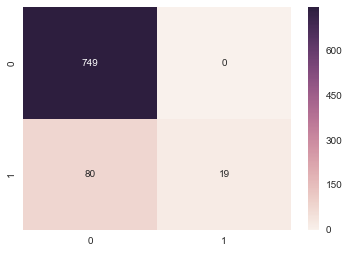

In [307]:
sns.heatmap(confusion_matrix(y_train, preds_train), annot=True, fmt='d')
print "AUC: %f" % (roc_auc_score(y_train, preds_train))

## Confusion matrix and ROC score trest

AUC: 0.973545


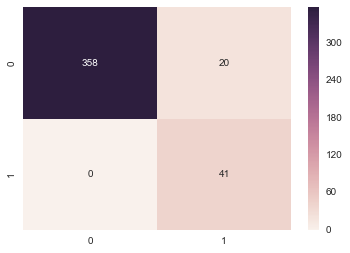

In [306]:
sns.heatmap(confusion_matrix(y_test, preds), annot=True, fmt='d')
print "AUC: %f" % (roc_auc_score(y_test, preds))

In [180]:
roc_auc_score(y_test, preds)

0.97354497354497349

In [172]:
cnn2 = load_model('cnn1_lpf5.0_resample600_smote.h5')

In [217]:
cnn2.layers

In [278]:
preds = cnn2.predict_classes(X_test_2d)

416/419 [============================>.] - ETA: 0s

In [279]:
roc_auc_score(y_test, preds)

0.97354497354497349

In [132]:
roc_auc_score(y_train, preds_train)

1.0

In [133]:
X_test_1d = X_test.reshape((len(X_test), 16*47, 1))
X_train_1d = X_train.reshape((len(X_train), 16*47, 1))
X_train_1d.shape

ValueError: total size of new array must be unchanged

In [39]:
16*47

752

In [41]:
from keras.layers import Convolution1D, AveragePooling1D

In [42]:
model = Sequential()

model.add(Convolution1D(nb_filter=6,
                        filter_length=3,
                        border_mode="valid",
                        activation="relu", 
                        input_shape=(752, 1)))
model.add(AveragePooling1D(pool_length=2))
model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.9))
model.add(Dense(1, init='normal', activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [43]:
model.fit(X_train_1d, y_train, nb_epoch=50, validation_data=(X_test_1d, y_test), callbacks=[earlystop])

Train on 848 samples, validate on 419 samples
Epoch 1/50
848/848 [==============================] - 0s - loss: 0.4830 - acc: 0.8715 - val_loss: 0.3315 - val_acc: 0.9021
Epoch 2/50
848/848 [==============================] - 0s - loss: 0.3799 - acc: 0.8833 - val_loss: 0.3270 - val_acc: 0.9021
Epoch 3/50
848/848 [==============================] - 0s - loss: 0.3775 - acc: 0.8833 - val_loss: 0.3239 - val_acc: 0.9021
Epoch 4/50
848/848 [==============================] - 0s - loss: 0.3939 - acc: 0.8833 - val_loss: 0.3323 - val_acc: 0.9021
Epoch 5/50
848/848 [==============================] - 0s - loss: 0.3743 - acc: 0.8833 - val_loss: 0.3203 - val_acc: 0.9021
Epoch 6/50
848/848 [==============================] - 0s - loss: 0.3728 - acc: 0.8833 - val_loss: 0.3231 - val_acc: 0.9021
Epoch 7/50
848/848 [==============================] - 0s - loss: 0.3662 - acc: 0.8833 - val_loss: 0.3226 - val_acc: 0.9021
Epoch 8/50
848/848 [==============================] - 0s - loss: 0.3836 - acc: 0.8833 - val_l

In [147]:
preds_train_1d = model.predict_classes(X_train_1d)
preds_1d = model.predict_classes(X_test_1d)

352/430 [=======================>......] - ETA: 0s

In [145]:
roc_auc_score(y_train, preds_train_1d)

0.82524271844660202

In [148]:
roc_auc_score(y_test, preds_1d)

0.49479166666666669

In [149]:
from keras.layers import LSTM

In [156]:
model = Sequential()
model.add(LSTM(4, input_shape=(9600, 1)))
model.add(Dense(1))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [46]:
model.fit(X_train_1d, y_train, nb_epoch=50, validation_data=(X_test_1d, y_test), callbacks=[earlystop])

Train on 848 samples, validate on 419 samples
Epoch 1/50
848/848 [==============================] - 0s - loss: 0.3746 - acc: 0.8833 - val_loss: 0.3244 - val_acc: 0.9021
Epoch 2/50
848/848 [==============================] - 0s - loss: 0.3708 - acc: 0.8833 - val_loss: 0.3230 - val_acc: 0.9021
Epoch 3/50
848/848 [==============================] - 0s - loss: 0.3818 - acc: 0.8833 - val_loss: 0.3219 - val_acc: 0.9021
Epoch 4/50
848/848 [==============================] - 0s - loss: 0.3703 - acc: 0.8833 - val_loss: 0.3243 - val_acc: 0.9021
Epoch 5/50
848/848 [==============================] - 0s - loss: 0.3862 - acc: 0.8833 - val_loss: 0.3233 - val_acc: 0.9021
Epoch 6/50
848/848 [==============================] - 0s - loss: 0.3781 - acc: 0.8833 - val_loss: 0.3277 - val_acc: 0.9021
Epoch 7/50
848/848 [==============================] - 0s - loss: 0.3664 - acc: 0.8833 - val_loss: 0.3203 - val_acc: 0.9021
Epoch 8/50
848/848 [==============================] - 0s - loss: 0.3753 - acc: 0.8833 - val_l